<a href="https://colab.research.google.com/drive/1DEN0E8ZHVD_D3MezIch6noNJ5wddqFLc?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fashion MNIST Convolutional Neural Network - Lottery Ticket**
1. Define Architecture

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

2. Train Model

In [ ]:
from torch.nn.utils import prune

def train(model, device, train_loader, optimizer):
    
    for batch_index, (inputs, labels) in enumerate(train_loader):
      model.train()
      inputs, labels = inputs.to(device), labels.to(device)

      output = model(inputs)
      loss = F.nll_loss(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch_index % 100 == 0:
        print('Training Progress: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            batch_index * len(inputs), len(train_loader.dataset),
            100. * batch_index / len(train_loader), loss.item()))

3. Reset Model Weights, Prune, then Retrain

In [ ]:
def lotteryTrain(model, device, train_loader, optimizer):
    # save initial state
    torch.save({"conv1.bias": model.state_dict()["conv1.bias"].detach().clone(),
                "conv2.bias": model.state_dict()["conv2.bias"].detach().clone(),
                "fc1.bias": model.state_dict()["fc1.bias"].detach().clone(),
                "fc2.bias": model.state_dict()["fc2.bias"].detach().clone(),
                
                "conv1.weight_orig": model.state_dict()["conv1.weight"].detach().clone(),
                "conv2.weight_orig": model.state_dict()["conv2.weight"].detach().clone(),
                "fc1.weight_orig": model.state_dict()["fc1.weight"].detach().clone(),
                "fc2.weight_orig": model.state_dict()["fc2.weight"].detach().clone()},
              "./fmnist_checkpoint.pt")
    
    # train model
    train(model, device, train_loader, optimizer)

    # prune half of all weights (TODO: half prune output layer?)
    to_prune = ((model.conv1, "weight"), (model.conv2, "weight"), (model.fc1, "weight"))
    output_layer = ((model.fc2, "weight"),)
    prune.global_unstructured(to_prune, pruning_method=prune.L1Unstructured, amount=0.5)
    prune.global_unstructured(output_layer, pruning_method=prune.L1Unstructured, amount=0.25)

    # load original weights, restart training
    checkpoint = torch.load("./fmnist_checkpoint.pt")
    checkpoint["conv1.weight_mask"] = model.state_dict()["conv1.weight_mask"].detach().clone()
    checkpoint["conv2.weight_mask"] = model.state_dict()["conv2.weight_mask"].detach().clone()
    checkpoint["fc1.weight_mask"] = model.state_dict()["fc1.weight_mask"].detach().clone()
    checkpoint["fc2.weight_mask"] = model.state_dict()["fc2.weight_mask"].detach().clone()
    model.load_state_dict(checkpoint)

    print('weights pruned and reset, training again')
    train(model, device, train_loader, optimizer)

4. Build Confusion Matrix/ Collect Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

def buildConfusionMatrix(model, testloader):
  # iterate over test data
  for inputs, labels in testloader:
          output = model(inputs) # Feed into Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                       index = [i for i in classes],
                       columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title("Confusion Matrix - Custom Pruned Model")
  plt.show()

  print(classification_report(y_true, y_pred, target_names=list(classes)))

5. Main function compiling previous steps

Training Progress: [0/60000 (0%)]	Loss: 2.307173
Training Progress: [6400/60000 (11%)]	Loss: 0.440680
Training Progress: [12800/60000 (21%)]	Loss: 0.358171
Training Progress: [19200/60000 (32%)]	Loss: 0.339079
Training Progress: [25600/60000 (43%)]	Loss: 0.311493
Training Progress: [32000/60000 (53%)]	Loss: 0.406289
Training Progress: [38400/60000 (64%)]	Loss: 0.277556
Training Progress: [44800/60000 (75%)]	Loss: 0.400729
Training Progress: [51200/60000 (85%)]	Loss: 0.378076
Training Progress: [57600/60000 (96%)]	Loss: 0.250899
weights pruned and reset, training again
Training Progress: [0/60000 (0%)]	Loss: 2.239125
Training Progress: [6400/60000 (11%)]	Loss: 0.445657
Training Progress: [12800/60000 (21%)]	Loss: 0.379650
Training Progress: [19200/60000 (32%)]	Loss: 0.327448
Training Progress: [25600/60000 (43%)]	Loss: 0.303706
Training Progress: [32000/60000 (53%)]	Loss: 0.385734
Training Progress: [38400/60000 (64%)]	Loss: 0.259242
Training Progress: [44800/60000 (75%)]	Loss: 0.397373

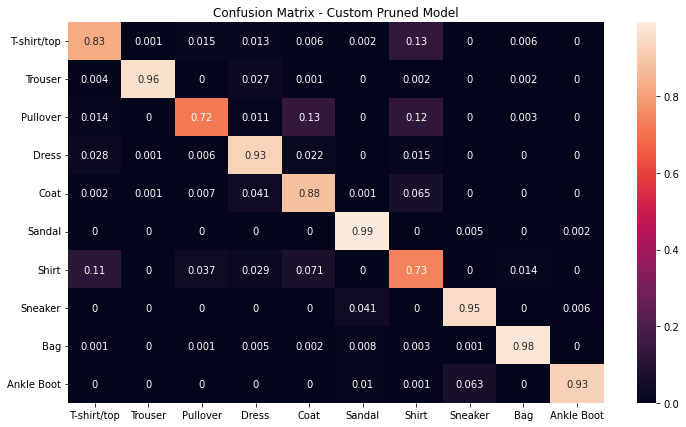

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.83      0.83      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.92      0.72      0.80      1000
       Dress       0.88      0.93      0.90      1000
        Coat       0.79      0.88      0.83      1000
      Sandal       0.94      0.99      0.97      1000
       Shirt       0.69      0.73      0.71      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.99      0.93      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
def main():
    use_cuda = torch.cuda.is_available()

    torch.manual_seed(1)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.FashionMNIST('../data', train=False,
                       transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    val_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = FashionModel().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    if use_cuda:
      start = torch.cuda.Event(enable_timing=True)
      end = torch.cuda.Event(enable_timing=True)

      start.record()
      lotteryTrain(model, device, train_loader, optimizer)
      end.record()
      torch.cuda.synchronize()
      print("\nTotal training time (1 epoch): " 
            + str(start.elapsed_time(end)/1000) + " seconds")

    else:
      lotteryTrain(model, device, train_loader, optimizer)
    
    buildConfusionMatrix(model, val_loader)

if __name__ == '__main__':
    main()